## Plotting observation-model comparisons of pressure and temperature

To explore the data, we can look at comparisons between the instrument data for bottom pressure & bottom temperature and modeled pressures & temperatures at the same location. 

This part of the code:
* reads the pressure data from each instrument as well as the model
* finds the nearest model gridpoint corresponding to each instrument's coordinates
* detrends the pressure data from the instruments
* plots detrended instrument data and corresponding model data on the same axes

The same steps are repeated to produce similar plots for observed & modeled temperatures. 

### Pressure plots

In [1]:
#import necessary modules 
import random
import math
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import numpy as np
import pandas as pd
import netCDF4 as nc

In [3]:
from os import listdir

In [5]:
# get a list of the available files
pfile_list = listdir('data/p_daily')
pfile_list.remove(pfile_list[0])
pfile_list

['LA22.nc',
 'LA23.nc',
 'LA25.nc',
 'LA28.nc',
 'LA30.nc',
 'LA32.nc',
 'LA33.nc',
 'LA34.nc',
 'LA39.nc',
 'LT01.nc',
 'LT03.nc',
 'LT04.nc',
 'LT06.nc',
 'LT07.nc',
 'LT10.nc',
 'LT11.nc',
 'LT12.nc',
 'LT13.nc',
 'LT14.nc',
 'LT16.nc',
 'LT20.nc']

In [17]:
# Load just one as an example
pfile = 'LT01.nc'
LT01 = nc.Dataset(pfile)
LT01

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    dimensions(sizes): n(1), str(4), obs(354)
    variables(dimensions): |S1 station id(str, n), float64 latitude(), float64 longitude(), float64 depth(), float64 time(obs), float64 pressure(obs)
    groups: 

In [16]:
import xarray as xr

In [233]:
#get list of station names out of file names 
sta = []
for fn in pfile_list:
    ft = str(fn)
    sta.append(ft.replace(".nc",""))

In [118]:
# get instrument locations and depths from pressure files
stalat = np.empty([len(pfile_list), 1])
stalon = np.empty([len(pfile_list), 1])
stadep = np.empty([len(pfile_list), 1])
for i in range(len(pfile_list)):
    temp = nc.Dataset('data/p_daily/' + pfile_list[i])
    stalat[i] = np.array(temp['latitude']).flatten()
    stalon[i] = np.array(temp['longitude']).flatten()
    stadep[i] = np.array(temp['depth']).flatten()

### Model Data

Loading pressure data from oceanographic model that corresponds to the instrument locations

In [157]:
#import modules 
from math import cos, sin, sqrt, pi, asin, acos

In [122]:
#load model data from netcdf
mpfile = 'data/CGOA_p.nc'
Pm = nc.Dataset(mpfile)
Pm

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    dimensions(sizes): y(117), x(84), t(384)
    variables(dimensions): float64 latitude(y), float64 longitude(x), float64 depth(y, x), float64 time(t), float64 pressure(t, y, x)
    groups: 

In [142]:
mlat = np.array(Pm['latitude'])
mlong = np.array(Pm['longitude'])

In [147]:
#function to calculate distance between a pair of station coordinates (stalat, stalong) and reference coordinates (x,y)
def distance(stalat, stalon, y, x):
    p = pi/180
    a = 0.5 - cos((y-stalat)*p)/2 + cos(stalat*p) * cos(y*p) * (1-cos((x-stalon)*p))/2
    return 12742 * asin(sqrt(a)) 

In [161]:
xlen = len(mlong)
ylen = len(mlat)

In [259]:
#function that retrieves the closest points on the model grid 
def closestpoint(stalat, stalon): 
    r=np.zeros((ylen, xlen))
    for i in range(ylen):
        for j in range(xlen):
            #distance of the station lat, long from the model grid lat, long points i, j
            r[i][j] = distance(stalat, stalon, mlat[i], mlong[j])
    y, x = np.unravel_index(r.argmin(), r.shape)
    return y, x #mlat[y], mlong[x]

In [260]:
close_lat = np.zeros(len(stalat))
close_lon = np.zeros(len(stalat))
for i in range(len(stalat)):
    for j in range(2):
        p = closestpoint(stalat[i],stalon[i])
        close_lat[i] = p[0]
        close_lon[i] = p[1]

In [261]:
stations = pd.DataFrame({'station':sta, 'lat':stalat[:,0], 'lon':stalon[:,0], 'depth':stadep[:,0], 'close_lat':close_lat, 'close_lon':close_lon})
stations.head()

,station,lat,lon,depth,close_lat,close_lon
0,LA22,55.257568,-155.152950,2130.0,38.0,40.0
1,LA23,54.916341,-155.237562,3977.0,32.0,40.0
2,LA25,54.890050,-155.940840,2622.0,32.0,34.0
3,LA28,54.898337,-156.603040,1852.0,32.0,28.0
4,LA30,54.672698,-157.420320,1564.0,28.0,21.0


In [264]:
#separate into 2, one for shelf locations and one for slope locations
#exclude instrument locations from p_daily that will be outside of the model domain 
shelf = stations.loc[(stations['depth'] < 300) & (stations['lon'] > -160) & (stations['lon'] < -150)]
slope = stations.loc[(stations['depth'] > 300) & (stations['lon'] > -160) & (stations['lon'] < -150)]

,station,lat,lon,depth,close_lat,close_lon
9,LT01,56.775555,-152.522757,156.0,63.0,62.0
10,LT03,57.866800,-154.166500,202.0,81.0,49.0
11,LT04,56.111769,-154.444618,157.0,52.0,46.0
12,LT06,56.216660,-155.997900,225.0,54.0,33.0
13,LT07,56.671183,-156.119948,262.0,61.0,32.0


### Data processing

The time series data from the instruments contains linear trends from external factors (e.g. instrument drift). To get the pressure variation signal, the data has to be detrended. We used a linear regression with scikit-learn to demonstrate how the trend is removed (scipy signal.detrend can be used for plotting). 

In [269]:
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score  

Running an example using the first station from slope (LA22) to show how detrending works

In [270]:
st_name = slope['station'].iloc[0]
fp = 'data/p_daily/' + st_name + '.nc'
temp = nc.Dataset(fp)

In [229]:
#constants for plotting
ampfac = 1/10065/0.01 # Pa to cm seawater
params = {'legend.fontsize': 14, \
          'xtick.labelsize':14, \
          'ytick.labelsize':14, \
          'font.size':14}
        plt.rcParams.update(params)

In [275]:
time = np.asarray(temp['time']).reshape(-1, 1)
pressure = np.asarray(temp['pressure']).reshape(-1, 1)

In [278]:
time_adj = time-time[0]
#linear regression model
regress = LinearRegression()
regress.fit(time_adj, pressure)
#calculate trend
predict = regress.predict(time_adj) 

In [393]:
detrended = [pressure[i]-predict[i] for i in range(len(pressure))]

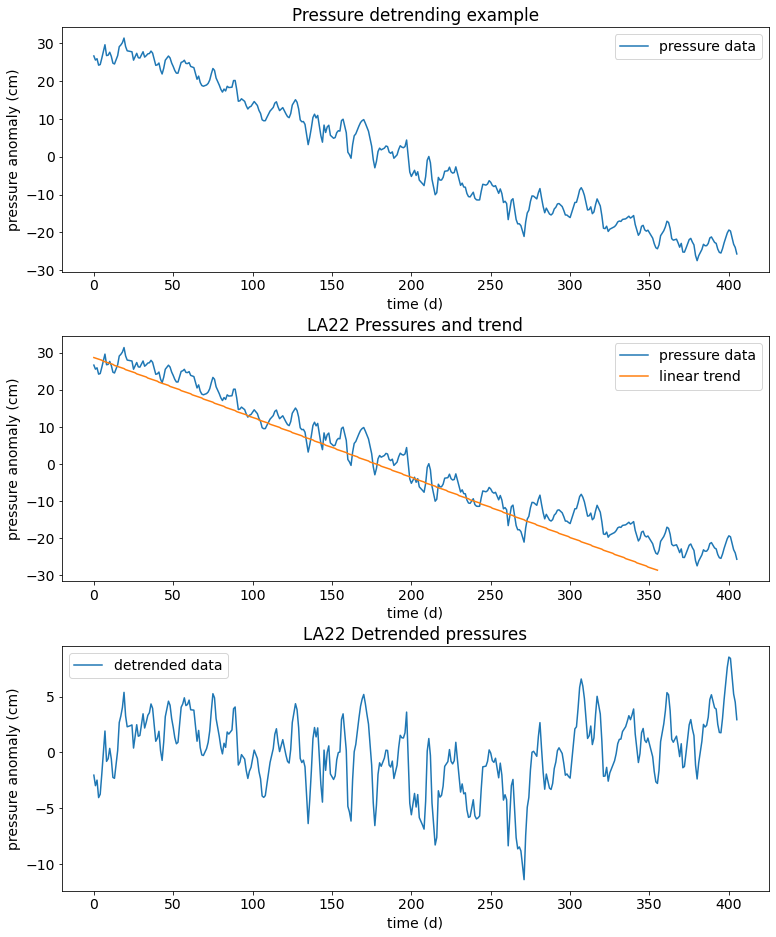

In [443]:
fig,ax = plt.subplots(3,1,figsize=(11,15))
ax[0].plot(time-time[0],(pressure-np.mean(pressure))*ampfac, label='pressure data');ax[0].set_xlabel('time (d)');ax[0].set_ylabel('pressure anomaly (cm)');ax[0].set_title('Pressure detrending example');ax[0].legend()
ax[1].plot(time_adj,(pressure-np.mean(pressure))*ampfac, label='pressure data');ax[1].plot((predict-np.mean(predict))*ampfac, label='linear trend');ax[1].set_xlabel('time (d)');ax[1].set_ylabel('pressure anomaly (cm)');ax[1].set_title(st_name + " Pressures and trend");ax[1].legend()
ax[2].plot(time_adj,(detrended-np.mean(detrended))*ampfac, label='detrended data');ax[2].set_xlabel('time (d)');ax[2].set_ylabel('pressure anomaly (cm)');ax[2].set_title(st_name + " Detrended pressures");ax[2].legend()
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

Plotting detrended pressure data vs model data at that location using the closest lat, long that was calculated: 

In [307]:
c_lat = slope['close_lat'].iloc[0]
c_lon = slope['close_lon'].iloc[0]

modt = np.asarray(Pm['time']).reshape(-1, 1)
modpressure = np.asarray(Pm['pressure'][:,c_lat,c_lon]).reshape(-1, 1)

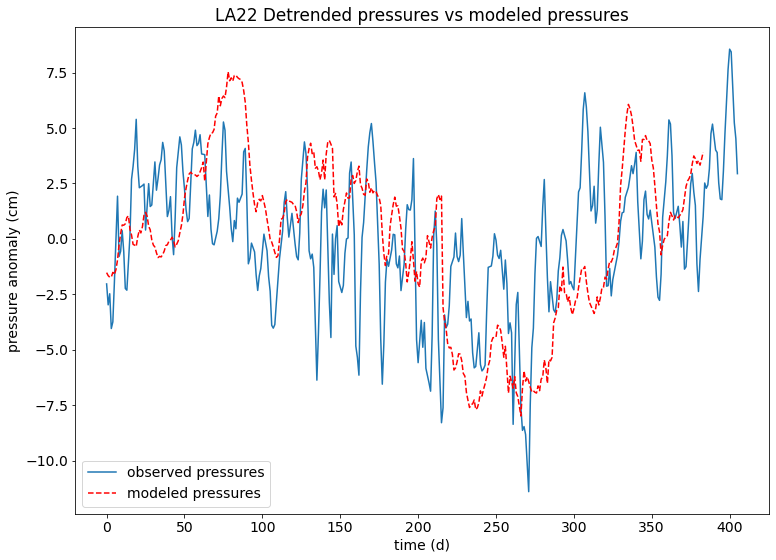

In [444]:
#plot example of measured & modeled pressure on the same graph
fig,ax = plt.subplots(figsize=(11,8))
ax.plot(time_adj,(detrended-np.mean(detrended))*ampfac)
ax.plot(modt_adj,(modpressure-np.mean(modpressure))*ampfac,color='red', linestyle='dashed')
ax.set_xlabel('time (d)');ax.set_ylabel('pressure anomaly (cm)');ax.set_title(st_name + " Detrended pressures vs modeled pressures")
plt.legend(['observed pressures','modeled pressures'])
plt.tight_layout()
plt.show()

In [363]:
from scipy import signal

In [377]:
#create a function to detrend data using linear regression
def detrend(t, ts):
    #linear regression model
    regress = LinearRegression()
    regress.fit(t, ts)
    #calculate trend
    predict = regress.predict(t) 
    detrended = [ts[i]-predict[i] for i in range(len(ts))]
    return detrended

In [448]:
#automate plotting all pressure data on same graph 
def readplot(df, scale, place):
    #make plot
    fig, ax1 = plt.subplots(figsize=(8, 18))
    #loop through all datasets 
    for i in range(len(df['station'])):
        #read data
        st_name = df['station'].iloc[i]
        fp = 'data/p_daily/' + st_name + '.nc'
        temp = nc.Dataset(fp)
        
        #instrument data to arrays
        time = np.asarray(temp['time']).reshape(-1, 1)
        pressure = np.asarray(temp['pressure']).reshape(-1, 1)
        time_adj = time-time[0]
       
        #detrend data
        detrended = detrend(time_adj, pressure)
        
        #access closest coordinates
        c_lat = df['close_lat'].iloc[i]
        c_lon = df['close_lon'].iloc[i]

        modt = np.asarray(Pm['time']).reshape(-1, 1)
        modpressure = np.asarray(Pm['pressure'][:,c_lat,c_lon]).reshape(-1, 1)
        
        #plot
        ax1.plot(time_adj, (detrended-np.mean(detrended))*ampfac + scale*i, linewidth=1)
        ax1.plot(modt_adj, (modpressure-np.mean(modpressure))*ampfac + scale*i, color='red', linestyle='dashed', linewidth=1)
        plt.annotate(st_name, (time_adj[-20], (detrended[-20]-np.mean(detrended))*ampfac + scale*i), textcoords="offset points", xytext=(0,10))
        
    ax1.set_xlabel('time (d)');ax1.set_ylabel('pressure anomaly (cm)');ax1.set_title("Observed vs modeled pressures (" + place + ")")
    plt.savefig('P_model-obs_'+place)
    plt.show()
    
                

Plotting the detrended instrument pressures vs oceanographic modeled pressures for the shelf data:

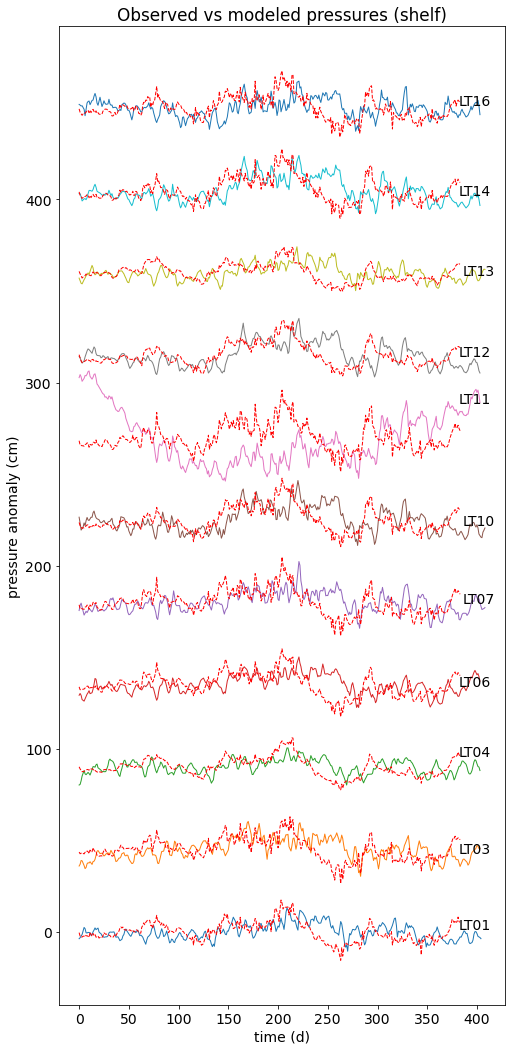

In [449]:
readplot(shelf, 45, 'shelf')

Plotting the detrended instrument pressures vs oceanographic modeled pressures for the slope data:

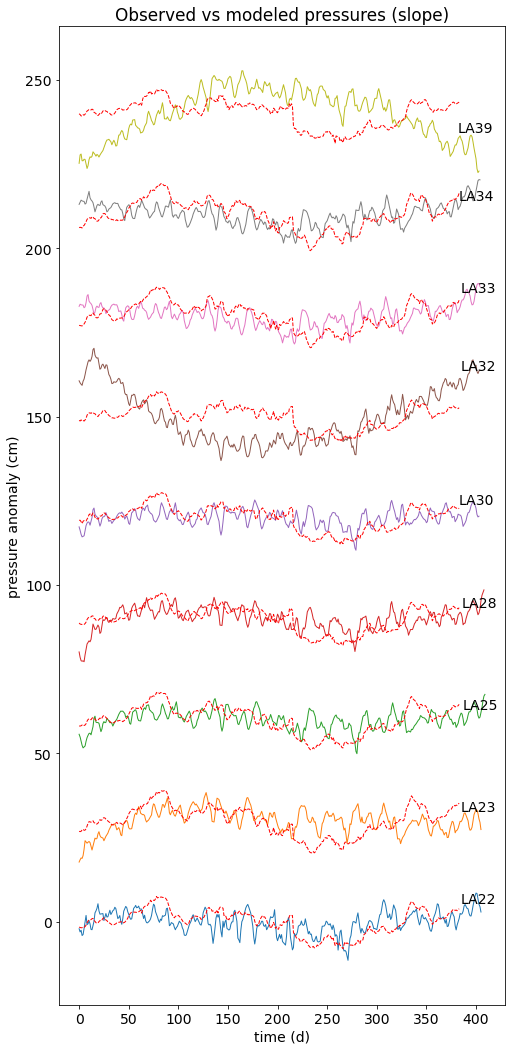

In [450]:
readplot(slope, 30, 'slope')

### Temperature plots

(Repeat all above steps to get the same plots for observed vs modeled temperatures)

In [395]:
# get a list of the available files
Tfile_list = listdir('data/T_daily')
Tfile_list.remove(Tfile_list[0])
Tfile_list

['LA23_T.nc',
 'LA25_T.nc',
 'LA30_T.nc',
 'LA32_T.nc',
 'LA33_T.nc',
 'LA34_T.nc',
 'LA39_T.nc',
 'LT01_T.nc',
 'LT03_T.nc',
 'LT04_T.nc',
 'LT06_T.nc',
 'LT07_T.nc',
 'LT10_T.nc',
 'LT11_T.nc',
 'LT12_T.nc',
 'LT13_T.nc',
 'LT14_T.nc',
 'LT16_T.nc',
 'LT20_T.nc']

In [396]:
#load model data from netcdf
mpfile = 'data/CGOA_T.nc'
Tm = nc.Dataset(mpfile)
Tm

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    dimensions(sizes): y(117), x(84), t(384)
    variables(dimensions): float64 latitude(y), float64 longitude(x), float64 depth(y, x), float64 time(t), float64 temperature(t, y, x)
    groups: 

In [397]:
Tlat = np.array(Tm['latitude'])
Tlong = np.array(Tm['longitude'])

xlen = len(Tlong)
ylen = len(Tlat)

In [400]:
#get list of station names out of file names 
T_sta = []
for fn in Tfile_list:
    ft = str(fn)
    ft = ft.replace(".nc","")
    T_sta.append(ft.replace("_T",""))

In [401]:
# get instrument locations and depths from pressure files
Tstalat = np.empty([len(Tfile_list), 1])
Tstalon = np.empty([len(Tfile_list), 1])
Tstadep = np.empty([len(Tfile_list), 1])
for i in range(len(Tfile_list)):
    temp = nc.Dataset('data/T_daily/' + Tfile_list[i])
    Tstalat[i] = np.array(temp['latitude']).flatten()
    Tstalon[i] = np.array(temp['longitude']).flatten()
    Tstadep[i] = np.array(temp['depth']).flatten()

In [403]:
Tclose_lat = np.zeros(len(Tstalat))
Tclose_lon = np.zeros(len(Tstalat))

for i in range(len(Tstalat)):
    for j in range(2):
        p = closestpoint(Tstalat[i],Tstalon[i])
        Tclose_lat[i] = p[0]
        Tclose_lon[i] = p[1]
        

array([32., 32., 28., 25., 19., 17., 65., 63., 81., 52., 54., 61., 44.,
       52., 37., 31., 45., 42., 30.])

In [406]:
Tstations = pd.DataFrame({'station':T_sta, 'lat':Tstalat[:,0], 'lon':Tstalon[:,0], 'depth':Tstadep[:,0], 'close_lat':Tclose_lat, 'close_lon':Tclose_lon})
#separate into 2, one for shelf locations and one for slope locations
#exclude instrument locations from p_daily that will be outside of the model domain 
Tshelf = Tstations.loc[(Tstations['depth'] < 300) & (Tstations['lon'] > -160) & (Tstations['lon'] < -150)]
Tslope = Tstations.loc[(Tstations['depth'] > 300) & (Tstations['lon'] > -160) & (Tstations['lon'] < -150)]
Tshelf.head()

,station,lat,lon,depth,close_lat,close_lon
7,LT01,56.775555,-152.522757,156.0,63.0,62.0
8,LT03,57.866800,-154.166500,202.0,81.0,49.0
9,LT04,56.111769,-154.444618,157.0,52.0,46.0
10,LT06,56.216660,-155.997900,225.0,54.0,33.0
11,LT07,56.671183,-156.119948,262.0,61.0,32.0


In [445]:
#automate plotting all T data on same graph 
def Treadplot(df, scale, place):
    #make plot
    fig, ax1 = plt.subplots(figsize=(8, 18))
    #loop through all datasets 
    for i in range(len(df['station'])):
        #read data
        st_name = df['station'].iloc[i]
        fp = 'data/T_daily/' + st_name + '_T.nc'
        temp = nc.Dataset(fp)
        
        #instrument data to arrays
        time = np.asarray(temp['time']).reshape(-1, 1)
        T = np.asarray(temp['temperature']).reshape(-1, 1)
        time_adj = time-time[0]
       
        #detrend data
        #detrended = detrend(time_adj, T)
        
        #access closest coordinates
        c_lat = df['close_lat'].iloc[i]
        c_lon = df['close_lon'].iloc[i]

        modt = np.asarray(Tm['time']).reshape(-1, 1)
        modT = np.asarray(Tm['temperature'][:,c_lat,c_lon]).reshape(-1, 1)
        
        #plot
        ax1.plot(time_adj, (T-np.mean(T)) + scale*i, linewidth=1)
        ax1.plot(modt_adj, (modT-np.mean(modT)) + scale*i, color='red', linestyle='dashed', linewidth=1)
        plt.annotate(st_name, (time_adj[-20], (T[-20]-np.mean(T)) + scale*i), textcoords="offset points", xytext=(0,10))
        
    ax1.set_xlabel('time (d)');ax1.set_ylabel('Temperature (C)');ax1.set_title("Observed vs modeled temperatures (" + place + ")")
    plt.savefig('T_model-obs_'+place)
    plt.show()
    
                

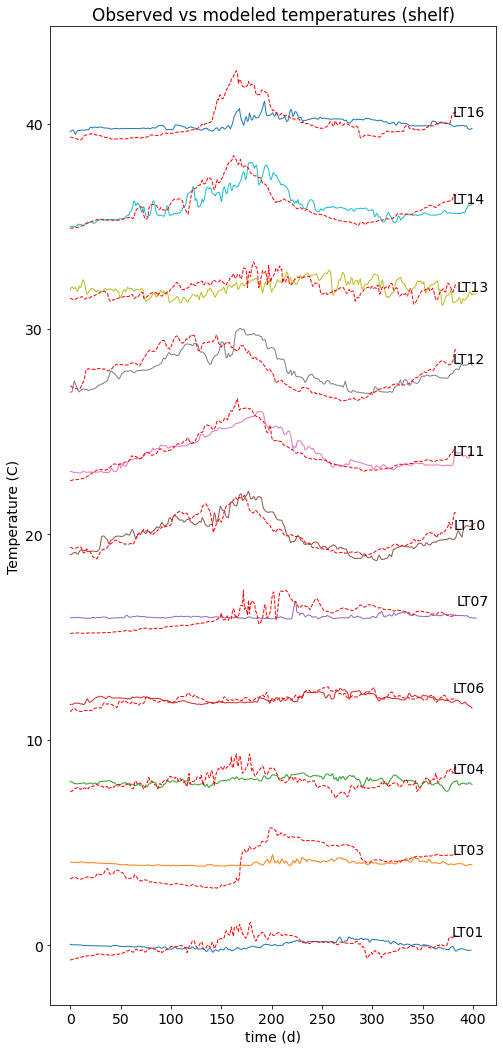

In [446]:
Treadplot(Tshelf, 4, 'shelf')

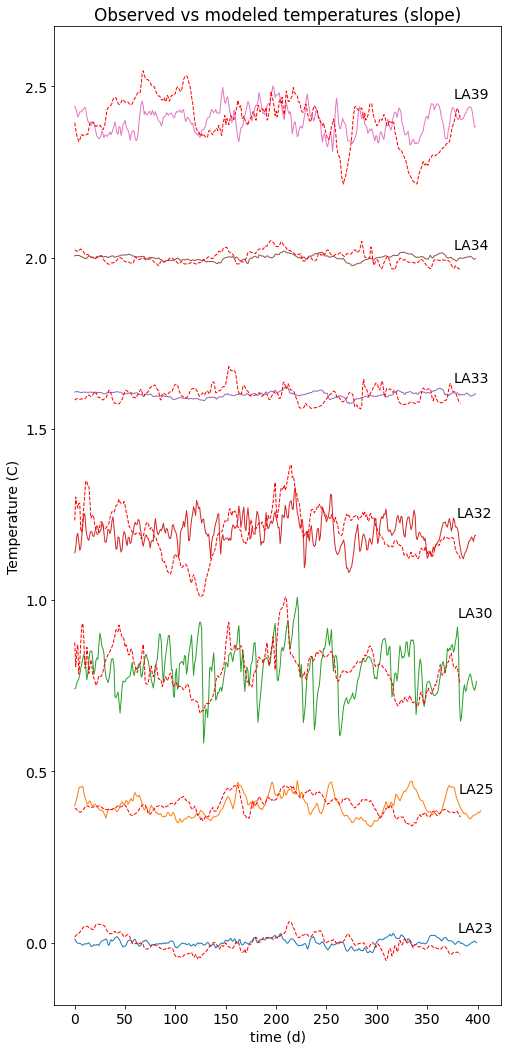

In [447]:
Treadplot(Tslope, 0.4, 'slope')